# Nvidia DGX GPU enabled Kubeflow pipeline example
In this example we demonstrate how to train and deploy machine learning model using Kubeflow Pipeline (KFP). This example trains and deploys image classifiers trained on [cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). For the model we used convolutional neural network implemented in [Tensorflow](https://www.tensorflow.org/). The architecture of the network is not important for the purpose of this example (although we use deep networks with multiple convolution layers to leverage as much of the GPU power for the purpose of presentation). This example can be run with CPU only setup with minor modifications (mentioned later).

**Prerequisites**
- Kubernetes cluster (where at least the one node has Nvidia GPU)
- Installed Kubeflow. Check out the `kubernetes-setup.md` file in this repository for step by step setup instructions.
- (Optional) As a bonus in this example we use MlFlow as a model registry (about [MLFlow](https://mlflow.org/)). You can install MLFlow with juju. Instructions [here](https://github.com/canonical/mlflow-operator)

**Notebook creation**
- After successful Kubeflow [setup](https://charmed-kubeflow.io/docs/install) please visit the the kubeflow dashboard url (if you used the guide is should be http://10.64.140.43.nip.io)
- Use credentials you configured in the setup 
- In the left panel click on **Notebooks tab**
- In the right top corner click on **+ New Notebook**
- Make sure to fill the fields according to image bellow

**Important**

This example was tested on drivers:
```
NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7
```
And ```tensorflow-gpu==2.10.0```. Check rest of the requirements in the attatched `requirements.txt`.

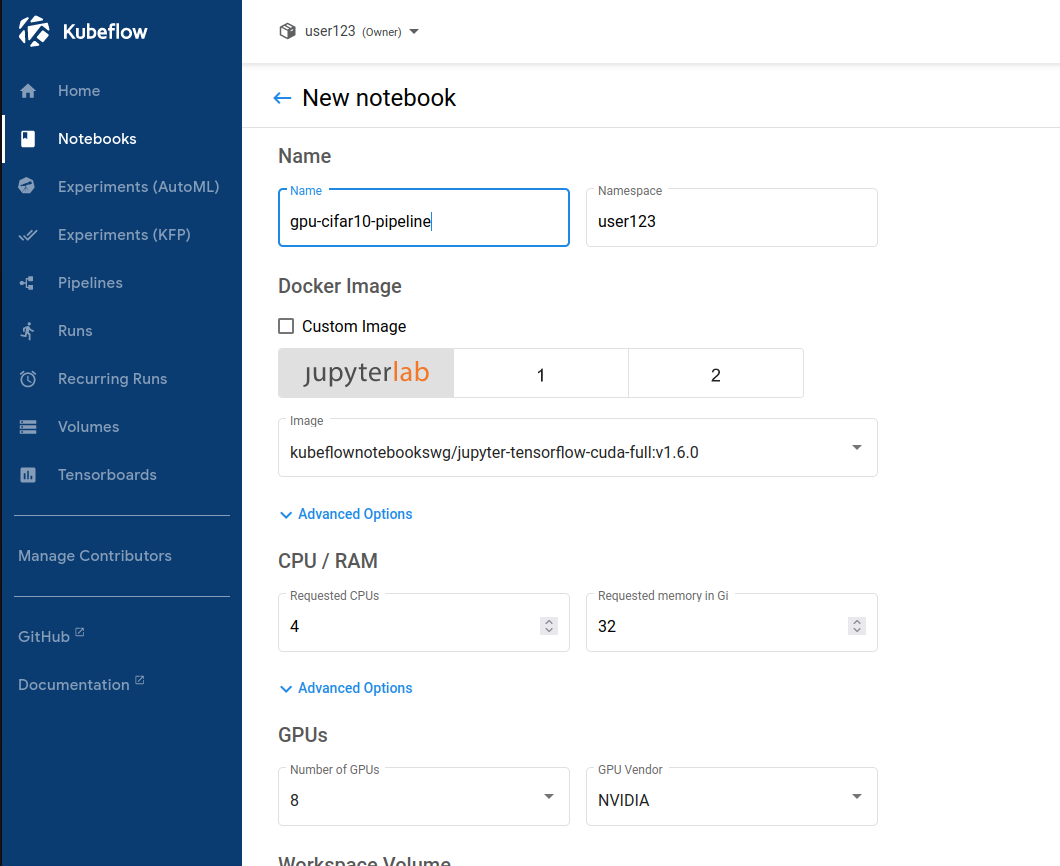

In [ ]:
# librarries to work with mlflow
!pip install mlflow boto3 awscli mlflow

In [ ]:
# kfp is librarry for kubeflow pipelines
!pip install kfp --upgrade -q

In [2]:
import kfp
from kfp import dsl

In [3]:
# In this cell we create a training task. Any training code can be provided here in any librarry kfp librarry packs it to the Pod and deployes to cluster.
# Note that the imports are inside function definition (common pattern for kfp)
# Read more about kfp librarry: https://kubeflow-pipelines.readthedocs.io/en/latest/source/kfp.html
# Here you can find other example of Kubeflow Pipeline with more steps: https://github.com/canonical/kubeflow-examples/tree/main/e2e-wine-kfp-mlflow

def trainning() -> str:
    import tensorflow as tf
    import os
    import mlflow
    import mlflow.keras
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D
    from tensorflow.keras.layers import MaxPooling2D
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Flatten
    
    device_type = 'GPU'
    devices = tf.config.experimental.list_physical_devices(
              device_type)
    devices_names = [d.name.split("e:")[1] for d in devices] # getting all GPU available
    
    (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
    X_train.shape, X_test.shape
    X_train_scaled = X_train/255
    X_test_scaled = X_test/255
    
    y_train_encoded = keras.utils.to_categorical(y_train, num_classes = 10, dtype = 'float32')
    y_test_encoded = keras.utils.to_categorical(y_test, num_classes = 10, dtype = 'float32')
    
    strategy = tf.distribute.MirroredStrategy(
           devices=devices_names[:8])
    with strategy.scope():
        model = keras.models.Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(10, activation='softmax'))
        # Compile model
        opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=64)
        
        # The next steps are responsible for storing the model in the mlflow repository
        with mlflow.start_run(run_name='cifar10_classiffier'):
            result = mlflow.keras.log_model(model, "model", registered_model_name="cnn_test")
            print(f"{mlflow.get_artifact_uri()}/{result.artifact_path}")
            return f"{mlflow.get_artifact_uri()}/{result.artifact_path}"

In [4]:
# This cells packs the code of the training function into kfp component 
training_op = kfp.components.create_component_from_func(
        func=trainning,
        output_component_file='train-component.yaml', # This is optional. It saves the component spec for future use.
        base_image='tensorflow/tensorflow:latest-gpu', # You can specify any base image even custom ones
        packages_to_install=['mlflow', 'boto3']) # If you want to install extra librarries you can provide them here

In the next step we create another Kubeflow pipeline component which will take the model from MLFlow and deploy it to the clustter using seldon core (more about Seldon [here](https://www.seldon.io/)). This component will deploy the trained model as a REST service. Seldon is installed as part of the Charmed Kubeflow installation.

**NOTE:** In the deployment bellow we use a secret with credentials to object storage (Kubeflow uses [Minio](https://min.io/) behind the scenes).This secret needs to be created.

**First** retriewe the minio credentials form you charmed kubeflow deployment. (make sure to change the admission-webhook unit name if you renemaed the component, you can check unit names wit `juju status`). You can install yq tool with `sudo snap install yq`.
```
$ juju show-unit admission-webhook/0 | yq .admission-webhook/*.relation-info[0].application-data
```

**Second** deploy the secret to the desired namespace (name of the namespace is the the name of your user the installation guide uses `admin`).
```
kubectl create secret generic seldon-init-container-secret -n admin \
  --from-literal=RCLONE_CONFIG_S3_TYPE='s3' \
  --from-literal=RCLONE_CONFIG_S3_PROVIDER='minio' \
  --from-literal=RCLONE_CONFIG_S3_ENV_AUTH=false \
  --from-literal=RCLONE_CONFIG_S3_ENDPOINT='http://minio.kubeflow.svc.cluster.local:9000' \
  --from-literal=RCLONE_CONFIG_S3_ACCESS_KEY_ID=<access-key> \
  --from-literal=RCLONE_CONFIG_S3_SECRET_ACCESS_KEY=<secret-key>
```


In [5]:
# Here we create SeldonDeployment which will serve model directly form mlflow registry. Make sure to use proper namespace (should be the same as your Kubeflow login)
# In the replicas section you can specify as many replicas as you need if you want to scale the model up

def deploy(model_uri:str = "default_model_uri"):
    import subprocess
    
    with open("/tmp/manifest.yaml", "w") as f:
        manifest = """    
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: mlflow
  namespace: user123
spec:
  name: cifar10
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - name: classifier
          image: seldonio/mlflowserver:1.14.0-dev
          imagePullPolicy: Always
          livenessProbe:
            initialDelaySeconds: 80
            failureThreshold: 200
            periodSeconds: 5
            successThreshold: 1
            httpGet:
              path: /health/ping
              port: http
              scheme: HTTP
          readinessProbe:
            initialDelaySeconds: 80
            failureThreshold: 200
            periodSeconds: 5
            successThreshold: 1
            httpGet:
              path: /health/ping
              port: http
              scheme: HTTP
    graph:
      children: []
      implementation: MLFLOW_SERVER
      modelUri: """+model_uri+"""
      envSecretRefName: seldon-init-container-secret
      name: classifier
    name: cifar10-classiffier
    replicas: 1
        """
        f.write(manifest)
    
    result = subprocess.call(['kubectl', 'apply', '-f', '/tmp/manifest.yaml', '-n', 'user123'])
    assert result == 0

In [6]:
# This cells packs the code of the deploy function into kfp component 
deploy_op = kfp.components.create_component_from_func(
        func=deploy,
        output_component_file='deploy-component.yaml', # This is optional. It saves the component spec for future use.
        base_image='bponieckiklotz/seldon-deploy:0.1',
        packages_to_install=[])

In [7]:
from kubernetes.client.models import V1EnvVar
from kfp.onprem import use_k8s_secret
import os

# update the vareiables with the output from
# juju show-unit admission-webhook/0 | yq .admission-webhook/*.relation-info[0].application-data

os.environ['MLFLOW_TRACKING_URI'] = "http://mlflow-server.kubeflow.svc.cluster.local:5000"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://minio.kubeflow.svc.cluster.local:9000"
os.environ["AWS_ACCESS_KEY_ID"] = "minio"
os.environ["AWS_SECRET_ACCESS_KEY"] = "5E3DSJDGKC9OJJB994EY0ZHZ4MDHIH"

# This last step creates the final Kubeflow pipeline
@dsl.pipeline(
    name="cifar10_cnn_classification",
    description="cifar10 pipeline",
)
def cifar_pipeline(url):    
    train_task = (training_op()
                 .add_env_variable(V1EnvVar(name='MLFLOW_TRACKING_URI', value='http://mlflow-server.kubeflow.svc.cluster.local:5000'))
                 .add_env_variable(V1EnvVar(name='MLFLOW_S3_ENDPOINT_URL', value='http://minio.kubeflow.svc.cluster.local:9000'))
                 #https://kubeflow-pipelines.readthedocs.io/en/stable/source/kfp.extensions.html#kfp.onprem.use_k8s_secret
                  .apply(use_k8s_secret(secret_name='mlpipeline-minio-artifact', k8s_secret_key_to_env={
                     'accesskey': 'AWS_ACCESS_KEY_ID',
                     'secretkey': 'AWS_SECRET_ACCESS_KEY',
                 })))
    deploy_task = deploy_op(model_uri=train_task.output)

In [49]:
# We can now directly trigger the pipeline
client = kfp.Client()
client.create_run_from_pipeline_func(
    cifar_pipeline,
    arguments={
        "url": "https://raw.githubusercontent.com/Barteus/kubeflow-examples/main/e2e-wine-kfp-mlflow/winequality-red.csv",
    })

# You can click on the link in the output to check for the status.
# Now pods should be created for each step of the pipeline in the namespace (name of the namespace is your login).
# At the end of pipeline the model is deployed to the same namespace 

RunPipelineResult(run_id=7b07b64a-cf6a-49c8-97fc-9ffc4f016999)

This is the expected end state of the pipeline

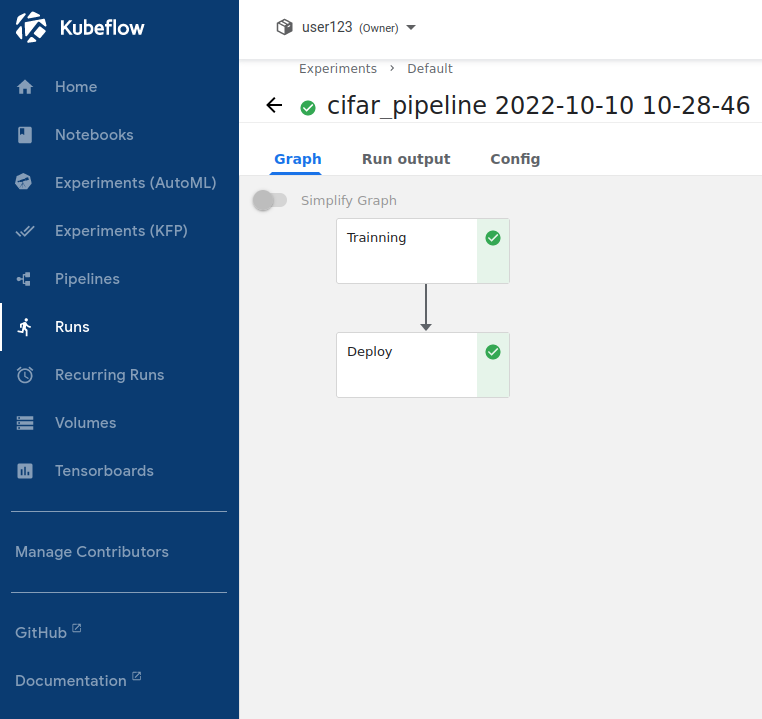

## Troubleshooting
During the run of the pipeline you can click on the task and go to the logs section. Logs may help you to further investigate the problems of the pipeline. 

In the pipeline overview window you can terminate the pipeline anytime you want (top right corner of the screen).

To predict against newly deployed SeldonDeployment you need to find the IP address of svc linked with the deployment. You can list all the services for your namespace wit the command (if `kubectl` is not recognised as command try `microk8s kubectl ...`).

```
$ kubectl get svc -n admin
```
*replace admin with the name of your namespace (username from login)

Now search for the appropriate service. Service name consists of `<seldondeployment-name>-<spec.name>` in this case `mlflow-cifar10-classiffier`. Get the clusterIp addresss. Replace the cell bellow with appropriate clusterIp addresss.

In [1]:
!curl  -s http://10.152.183.77:8000/api/v0.1/predictions \
  -H "Content-Type: application/json" \
  -d '{"data":{"ndarray":[[[[0.6196078431372549, 0.4392156862745098, 0.19215686274509805], [0.6235294117647059, 0.43529411764705883, 0.1843137254901961], [0.6470588235294118, 0.4549019607843137, 0.2], [0.6509803921568628, 0.4627450980392157, 0.20784313725490197], [0.6274509803921569, 0.4392156862745098, 0.1803921568627451], [0.611764705882353, 0.42745098039215684, 0.1607843137254902], [0.6352941176470588, 0.45098039215686275, 0.1843137254901961], [0.6235294117647059, 0.44313725490196076, 0.17647058823529413], [0.6196078431372549, 0.43529411764705883, 0.17254901960784313], [0.6235294117647059, 0.44313725490196076, 0.1607843137254902], [0.6313725490196078, 0.4549019607843137, 0.1607843137254902], [0.6274509803921569, 0.43529411764705883, 0.20392156862745098], [0.6313725490196078, 0.43529411764705883, 0.19215686274509805], [0.6509803921568628, 0.4588235294117647, 0.1607843137254902], [0.6627450980392157, 0.4588235294117647, 0.17647058823529413], [0.6666666666666666, 0.4666666666666667, 0.17254901960784313], [0.6549019607843137, 0.4588235294117647, 0.1568627450980392], [0.6352941176470588, 0.44313725490196076, 0.14901960784313725], [0.6274509803921569, 0.43529411764705883, 0.15294117647058825], [0.6274509803921569, 0.4392156862745098, 0.16862745098039217], [0.611764705882353, 0.42745098039215684, 0.17254901960784313], [0.5843137254901961, 0.4196078431372549, 0.17647058823529413], [0.5882352941176471, 0.4196078431372549, 0.17647058823529413], [0.5803921568627451, 0.41568627450980394, 0.16862745098039217], [0.5843137254901961, 0.4196078431372549, 0.17254901960784313], [0.5607843137254902, 0.396078431372549, 0.15294117647058825], [0.5490196078431373, 0.3843137254901961, 0.16862745098039217], [0.5529411764705883, 0.3803921568627451, 0.1607843137254902], [0.5607843137254902, 0.3803921568627451, 0.14901960784313725], [0.5372549019607843, 0.37254901960784315, 0.1411764705882353], [0.49411764705882355, 0.3568627450980392, 0.1411764705882353], [0.4549019607843137, 0.3333333333333333, 0.12941176470588237]], [[0.596078431372549, 0.4392156862745098, 0.2], [0.592156862745098, 0.43137254901960786, 0.1568627450980392], [0.6235294117647059, 0.4470588235294118, 0.17647058823529413], [0.6509803921568628, 0.4549019607843137, 0.2196078431372549], [0.6352941176470588, 0.4392156862745098, 0.19215686274509805], [0.6274509803921569, 0.44313725490196076, 0.16862745098039217], [0.6431372549019608, 0.4588235294117647, 0.1843137254901961], [0.6352941176470588, 0.4470588235294118, 0.17647058823529413], [0.6392156862745098, 0.4549019607843137, 0.1803921568627451], [0.611764705882353, 0.43137254901960786, 0.14901960784313725], [0.6078431372549019, 0.43529411764705883, 0.1607843137254902], [0.6235294117647059, 0.43137254901960786, 0.21176470588235294], [0.6392156862745098, 0.44313725490196076, 0.20392156862745098], [0.6666666666666666, 0.4666666666666667, 0.1607843137254902], [0.6705882352941176, 0.4588235294117647, 0.1568627450980392], [0.6705882352941176, 0.45098039215686275, 0.12941176470588237], [0.6627450980392157, 0.45098039215686275, 0.11764705882352941], [0.6274509803921569, 0.43529411764705883, 0.12941176470588237], [0.6039215686274509, 0.4392156862745098, 0.1607843137254902], [0.592156862745098, 0.45098039215686275, 0.19607843137254902], [0.5686274509803921, 0.43137254901960786, 0.20784313725490197], [0.5450980392156862, 0.40784313725490196, 0.21568627450980393], [0.5490196078431373, 0.4, 0.20392156862745098], [0.5529411764705883, 0.39215686274509803, 0.18823529411764706], [0.5843137254901961, 0.4117647058823529, 0.19607843137254902], [0.5764705882352941, 0.4, 0.1803921568627451], [0.5686274509803921, 0.4, 0.17647058823529413], [0.5568627450980392, 0.3803921568627451, 0.14901960784313725], [0.5607843137254902, 0.3843137254901961, 0.13333333333333333], [0.5333333333333333, 0.37254901960784315, 0.12156862745098039], [0.49019607843137253, 0.3568627450980392, 0.12549019607843137], [0.4666666666666667, 0.34509803921568627, 0.13333333333333333]], [[0.592156862745098, 0.43137254901960786, 0.1843137254901961], [0.592156862745098, 0.42745098039215684, 0.12941176470588237], [0.6196078431372549, 0.43529411764705883, 0.1411764705882353], [0.6549019607843137, 0.43529411764705883, 0.18823529411764706], [0.6274509803921569, 0.41568627450980394, 0.16470588235294117], [0.6392156862745098, 0.45098039215686275, 0.17254901960784313], [0.6470588235294118, 0.4588235294117647, 0.17647058823529413], [0.6470588235294118, 0.4588235294117647, 0.17647058823529413], [0.6392156862745098, 0.45098039215686275, 0.16862745098039217], [0.6352941176470588, 0.45098039215686275, 0.16862745098039217], [0.6196078431372549, 0.4470588235294118, 0.18823529411764706], [0.615686274509804, 0.42745098039215684, 0.2235294117647059], [0.6313725490196078, 0.43529411764705883, 0.2], [0.6509803921568628, 0.45098039215686275, 0.14901960784313725], [0.6549019607843137, 0.4470588235294118, 0.1450980392156863], [0.6627450980392157, 0.44313725490196076, 0.13725490196078433], [0.6666666666666666, 0.4549019607843137, 0.15294117647058825], [0.6235294117647059, 0.4470588235294118, 0.1843137254901961], [0.5686274509803921, 0.43529411764705883, 0.21176470588235294], [0.4745098039215686, 0.3764705882352941, 0.19215686274509805], [0.43137254901960786, 0.35294117647058826, 0.20392156862745098], [0.3843137254901961, 0.3058823529411765, 0.19607843137254902], [0.396078431372549, 0.30196078431372547, 0.1843137254901961], [0.4470588235294118, 0.3333333333333333, 0.19607843137254902], [0.47058823529411764, 0.33725490196078434, 0.18823529411764706], [0.5254901960784314, 0.3764705882352941, 0.21568627450980393], [0.5607843137254902, 0.403921568627451, 0.2], [0.5490196078431373, 0.38823529411764707, 0.15294117647058825], [0.5568627450980392, 0.38823529411764707, 0.13725490196078433], [0.5450980392156862, 0.3843137254901961, 0.13333333333333333], [0.5098039215686274, 0.37254901960784315, 0.13333333333333333], [0.47058823529411764, 0.34901960784313724, 0.12941176470588237]], [[0.6078431372549019, 0.4196078431372549, 0.1568627450980392], [0.6078431372549019, 0.43137254901960786, 0.12549019607843137], [0.6274509803921569, 0.42745098039215684, 0.12156862745098039], [0.6823529411764706, 0.4392156862745098, 0.17254901960784313], [0.6549019607843137, 0.43137254901960786, 0.16862745098039217], [0.6549019607843137, 0.4588235294117647, 0.1803921568627451], [0.6627450980392157, 0.47058823529411764, 0.18823529411764706], [0.6627450980392157, 0.4666666666666667, 0.18823529411764706], [0.6470588235294118, 0.45098039215686275, 0.17254901960784313], [0.6470588235294118, 0.4588235294117647, 0.17647058823529413], [0.6549019607843137, 0.4823529411764706, 0.2235294117647059], [0.7490196078431373, 0.5725490196078431, 0.37254901960784315], [0.6941176470588235, 0.5098039215686274, 0.29411764705882354], [0.615686274509804, 0.43529411764705883, 0.1607843137254902], [0.6352941176470588, 0.45098039215686275, 0.1843137254901961], [0.6431372549019608, 0.4470588235294118, 0.21176470588235294], [0.6196078431372549, 0.4392156862745098, 0.22745098039215686], [0.5843137254901961, 0.43529411764705883, 0.2627450980392157], [0.40784313725490196, 0.3137254901960784, 0.1843137254901961], [0.403921568627451, 0.3411764705882353, 0.2549019607843137], [0.3843137254901961, 0.35294117647058826, 0.2980392156862745], [0.3607843137254902, 0.35294117647058826, 0.32941176470588235], [0.3137254901960784, 0.29411764705882354, 0.25882352941176473], [0.2901960784313726, 0.24705882352941178, 0.19607843137254902], [0.33725490196078434, 0.27450980392156865, 0.20392156862745098], [0.3254901960784314, 0.24313725490196078, 0.15294117647058825], [0.44313725490196076, 0.3333333333333333, 0.17647058823529413], [0.5176470588235295, 0.3843137254901961, 0.1803921568627451], [0.5490196078431373, 0.4, 0.16862745098039217], [0.5490196078431373, 0.396078431372549, 0.15294117647058825], [0.5333333333333333, 0.38823529411764707, 0.15294117647058825], [0.4980392156862745, 0.3686274509803922, 0.1411764705882353]], [[0.6078431372549019, 0.4196078431372549, 0.1607843137254902], [0.611764705882353, 0.4470588235294118, 0.18823529411764706], [0.6313725490196078, 0.45098039215686275, 0.19215686274509805], [0.6666666666666666, 0.4470588235294118, 0.1843137254901961], [0.6627450980392157, 0.4470588235294118, 0.16862745098039217], [0.6392156862745098, 0.44313725490196076, 0.1568627450980392], [0.6627450980392157, 0.47058823529411764, 0.1843137254901961], [0.6509803921568628, 0.4549019607843137, 0.17254901960784313], [0.6431372549019608, 0.44313725490196076, 0.1607843137254902], [0.6431372549019608, 0.4549019607843137, 0.16470588235294117], [0.6784313725490196, 0.5019607843137255, 0.23137254901960785], [0.9647058823529412, 0.8392156862745098, 0.6431372549019608], [0.7647058823529411, 0.611764705882353, 0.4196078431372549], [0.592156862745098, 0.4470588235294118, 0.2196078431372549], [0.5725490196078431, 0.43529411764705883, 0.23529411764705882], [0.5568627450980392, 0.4235294117647059, 0.2784313725490196], [0.43529411764705883, 0.3137254901960784, 0.19607843137254902], [0.3058823529411765, 0.20784313725490197, 0.12156862745098039], [0.3333333333333333, 0.27058823529411763, 0.2196078431372549], [0.44313725490196076, 0.403921568627451, 0.3843137254901961], [0.4392156862745098, 0.43137254901960786, 0.43529411764705883], [0.41568627450980394, 0.4470588235294118, 0.4627450980392157], [0.3803921568627451, 0.4, 0.4117647058823529], [0.36470588235294116, 0.3686274509803922, 0.36470588235294116], [0.2901960784313726, 0.2823529411764706, 0.2627450980392157], [0.32941176470588235, 0.3058823529411765, 0.27450980392156865], [0.3333333333333333, 0.28627450980392155, 0.1843137254901961], [0.4117647058823529, 0.3254901960784314, 0.17647058823529413], [0.5019607843137255, 0.3764705882352941, 0.18823529411764706], [0.5411764705882353, 0.396078431372549, 0.1803921568627451], [0.5215686274509804, 0.3686274509803922, 0.1411764705882353], [0.5058823529411764, 0.36470588235294116, 0.1411764705882353]], [[0.5803921568627451, 0.42745098039215684, 0.21176470588235294], [0.5215686274509804, 0.40784313725490196, 0.25098039215686274], [0.5098039215686274, 0.39215686274509803, 0.2235294117647059], [0.5764705882352941, 0.4392156862745098, 0.20784313725490197], [0.6313725490196078, 0.45098039215686275, 0.17254901960784313], [0.6470588235294118, 0.44313725490196076, 0.15294117647058825], [0.6549019607843137, 0.4549019607843137, 0.1607843137254902], [0.6549019607843137, 0.45098039215686275, 0.1607843137254902], [0.6392156862745098, 0.43529411764705883, 0.1450980392156863], [0.6470588235294118, 0.4549019607843137, 0.15294117647058825], [0.6392156862745098, 0.4627450980392157, 0.16470588235294117], [0.7058823529411765, 0.5411764705882353, 0.3333333333333333], [0.615686274509804, 0.47843137254901963, 0.3058823529411765], [0.5019607843137255, 0.4, 0.22745098039215686], [0.3803921568627451, 0.29411764705882354, 0.16862745098039217], [0.25882352941176473, 0.19607843137254902, 0.12156862745098039], [0.27058823529411763, 0.22745098039215686, 0.16862745098039217], [0.25882352941176473, 0.2196078431372549, 0.17647058823529413], [0.34901960784313724, 0.3254901960784314, 0.2980392156862745], [0.4627450980392157, 0.44313725490196076, 0.43137254901960786], [0.47843137254901963, 0.4745098039215686, 0.47058823529411764], [0.4666666666666667, 0.47843137254901963, 0.47843137254901963], [0.4470588235294118, 0.4549019607843137, 0.4549019607843137], [0.3686274509803922, 0.3764705882352941, 0.3764705882352941], [0.38823529411764707, 0.39215686274509803, 0.3803921568627451], [0.3568627450980392, 0.3568627450980392, 0.33725490196078434], [0.22745098039215686, 0.22745098039215686, 0.1843137254901961], [0.2627450980392157, 0.22745098039215686, 0.1450980392156863], [0.4235294117647059, 0.32941176470588235, 0.19215686274509805], [0.5490196078431373, 0.4117647058823529, 0.22745098039215686], [0.5411764705882353, 0.3843137254901961, 0.17254901960784313], [0.5254901960784314, 0.37254901960784315, 0.1568627450980392]], [[0.4980392156862745, 0.39215686274509803, 0.2235294117647059], [0.42745098039215684, 0.37254901960784315, 0.3137254901960784], [0.1843137254901961, 0.1450980392156863, 0.06666666666666667], [0.34509803921568627, 0.2901960784313726, 0.10980392156862745], [0.6, 0.4588235294117647, 0.18823529411764706], [0.6666666666666666, 0.4627450980392157, 0.16862745098039217], [0.6588235294117647, 0.45098039215686275, 0.1568627450980392], [0.6666666666666666, 0.4627450980392157, 0.16862745098039217], [0.6627450980392157, 0.4588235294117647, 0.16470588235294117], [0.6509803921568628, 0.4549019607843137, 0.1450980392156863], [0.6431372549019608, 0.47058823529411764, 0.15294117647058825], [0.5764705882352941, 0.4196078431372549, 0.20392156862745098], [0.5058823529411764, 0.3843137254901961, 0.23137254901960785], [0.4980392156862745, 0.4235294117647059, 0.29411764705882354], [0.39215686274509803, 0.3411764705882353, 0.27450980392156865], [0.26666666666666666, 0.2627450980392157, 0.2235294117647059], [0.3058823529411765, 0.3254901960784314, 0.2823529411764706], [0.2823529411764706, 0.29411764705882354, 0.25098039215686274], [0.3254901960784314, 0.32941176470588235, 0.2901960784313726], [0.5176470588235295, 0.5098039215686274, 0.4745098039215686], [0.5725490196078431, 0.5568627450980392, 0.5176470588235295], [0.48627450980392156, 0.4627450980392157, 0.4235294117647059], [0.4117647058823529, 0.38823529411764707, 0.35294117647058826], [0.4196078431372549, 0.4, 0.3686274509803922], [0.45098039215686275, 0.43529411764705883, 0.403921568627451], [0.3333333333333333, 0.3254901960784314, 0.30196078431372547], [0.24705882352941178, 0.2784313725490196, 0.27058823529411763], [0.1803921568627451, 0.1843137254901961, 0.15294117647058825], [0.30980392156862746, 0.23921568627450981, 0.1411764705882353], [0.5176470588235295, 0.3843137254901961, 0.22745098039215686], [0.5529411764705883, 0.38823529411764707, 0.18823529411764706], [0.5254901960784314, 0.36470588235294116, 0.15294117647058825]], [[0.5137254901960784, 0.45098039215686275, 0.35294117647058826], [0.38823529411764707, 0.3764705882352941, 0.3607843137254902], [0.16470588235294117, 0.16862745098039217, 0.14901960784313725], [0.27450980392156865, 0.25098039215686274, 0.1607843137254902], [0.5607843137254902, 0.43529411764705883, 0.2196078431372549], [0.6549019607843137, 0.4588235294117647, 0.16470588235294117], [0.6470588235294118, 0.4470588235294118, 0.1411764705882353], [0.6588235294117647, 0.4549019607843137, 0.15294117647058825], [0.6705882352941176, 0.4666666666666667, 0.19215686274509805], [0.6313725490196078, 0.44313725490196076, 0.2], [0.5490196078431373, 0.42745098039215684, 0.2], [0.47058823529411764, 0.3686274509803922, 0.19215686274509805], [0.5098039215686274, 0.43137254901960786, 0.30196078431372547], [0.5647058823529412, 0.5137254901960784, 0.4196078431372549], [0.4549019607843137, 0.41568627450980394, 0.36470588235294116], [0.34509803921568627, 0.3411764705882353, 0.30980392156862746], [0.3568627450980392, 0.37254901960784315, 0.34509803921568627], [0.3333333333333333, 0.34509803921568627, 0.3215686274509804], [0.30196078431372547, 0.30196078431372547, 0.27058823529411763], [0.48627450980392156, 0.4627450980392157, 0.4196078431372549], [0.6392156862745098, 0.6, 0.5490196078431373], [0.5333333333333333, 0.48627450980392156, 0.4392156862745098], [0.4, 0.36470588235294116, 0.3176470588235294], [0.41568627450980394, 0.3843137254901961, 0.34509803921568627], [0.39215686274509803, 0.36470588235294116, 0.32941176470588235], [0.3333333333333333, 0.3176470588235294, 0.2901960784313726], [0.21176470588235294, 0.23529411764705882, 0.22745098039215686], [0.19215686274509805, 0.20784313725490197, 0.19215686274509805], [0.2235294117647059, 0.1843137254901961, 0.12549019607843137], [0.4196078431372549, 0.3254901960784314, 0.19607843137254902], [0.5411764705882353, 0.403921568627451, 0.2], [0.5333333333333333, 0.3803921568627451, 0.15294117647058825]], [[0.6666666666666666, 0.6313725490196078, 0.5647058823529412], [0.403921568627451, 0.4117647058823529, 0.4117647058823529], [0.21176470588235294, 0.22745098039215686, 0.23137254901960785], [0.48627450980392156, 0.4745098039215686, 0.44313725490196076], [0.6, 0.48627450980392156, 0.3215686274509804], [0.6313725490196078, 0.44313725490196076, 0.16862745098039217], [0.6392156862745098, 0.4588235294117647, 0.1607843137254902], [0.6509803921568628, 0.47843137254901963, 0.19607843137254902], [0.6470588235294118, 0.4745098039215686, 0.25882352941176473], [0.6823529411764706, 0.5294117647058824, 0.37254901960784315], [0.44313725490196076, 0.34901960784313724, 0.23137254901960785], [0.49019607843137253, 0.4117647058823529, 0.3058823529411765], [0.615686274509804, 0.5529411764705883, 0.4745098039215686], [0.611764705882353, 0.5607843137254902, 0.5019607843137255], [0.4745098039215686, 0.43529411764705883, 0.396078431372549], [0.33725490196078434, 0.3137254901960784, 0.2901960784313726], [0.3215686274509804, 0.3176470588235294, 0.30196078431372547], [0.32941176470588235, 0.3333333333333333, 0.3215686274509804], [0.3137254901960784, 0.3058823529411765, 0.28627450980392155], [0.3176470588235294, 0.2784313725490196, 0.23921568627450981], [0.5411764705882353, 0.49019607843137253, 0.4392156862745098], [0.5725490196078431, 0.5294117647058824, 0.4823529411764706], [0.44313725490196076, 0.403921568627451, 0.36470588235294116], [0.3411764705882353, 0.30980392156862746, 0.27450980392156865], [0.3254901960784314, 0.30196078431372547, 0.27058823529411763], [0.33725490196078434, 0.3215686274509804, 0.2980392156862745], [0.2784313725490196, 0.28627450980392155, 0.2627450980392157], [0.2196078431372549, 0.2235294117647059, 0.20784313725490197], [0.1568627450980392, 0.13725490196078433, 0.10588235294117647], [0.2901960784313726, 0.23137254901960785, 0.13725490196078433], [0.5215686274509804, 0.41568627450980394, 0.23137254901960785], [0.5372549019607843, 0.403921568627451, 0.17647058823529413]], [[0.7058823529411765, 0.6901960784313725, 0.6392156862745098], [0.5254901960784314, 0.5450980392156862, 0.5607843137254902], [0.3686274509803922, 0.39215686274509803, 0.4117647058823529], [0.6039215686274509, 0.6039215686274509, 0.5843137254901961], [0.6823529411764706, 0.5843137254901961, 0.4392156862745098], [0.6196078431372549, 0.4549019607843137, 0.2], [0.611764705882353, 0.4549019607843137, 0.1843137254901961], [0.6, 0.4627450980392157, 0.23529411764705882], [0.8117647058823529, 0.7058823529411765, 0.5725490196078431], [0.9294117647058824, 0.8392156862745098, 0.7764705882352941], [0.8117647058823529, 0.7058823529411765, 0.6509803921568628], [0.611764705882353, 0.5137254901960784, 0.4666666666666667], [0.6823529411764706, 0.6, 0.5686274509803921], [0.5803921568627451, 0.5137254901960784, 0.49019607843137253], [0.49019607843137253, 0.43137254901960786, 0.4196078431372549], [0.36470588235294116, 0.3333333333333333, 0.30980392156862746], [0.33725490196078434, 0.32941176470588235, 0.30980392156862746], [0.2901960784313726, 0.2901960784313726, 0.2784313725490196], [0.23137254901960785, 0.2235294117647059, 0.20784313725490197], [0.2980392156862745, 0.26666666666666666, 0.22745098039215686], [0.5372549019607843, 0.49019607843137253, 0.4392156862745098], [0.5607843137254902, 0.5215686274509804, 0.47843137254901963], [0.5215686274509804, 0.48627450980392156, 0.4470588235294118], [0.41568627450980394, 0.3843137254901961, 0.34901960784313724], [0.33725490196078434, 0.3176470588235294, 0.2901960784313726], [0.3411764705882353, 0.3333333333333333, 0.3058823529411765], [0.32941176470588235, 0.3333333333333333, 0.3058823529411765], [0.29411764705882354, 0.2980392156862745, 0.2784313725490196], [0.19607843137254902, 0.19215686274509805, 0.16862745098039217], [0.1568627450980392, 0.11764705882352941, 0.058823529411764705], [0.37254901960784315, 0.29411764705882354, 0.17254901960784313], [0.5176470588235295, 0.403921568627451, 0.2235294117647059]], [[0.7176470588235294, 0.7176470588235294, 0.6862745098039216], [0.4235294117647059, 0.4549019607843137, 0.47843137254901963], [0.5568627450980392, 0.592156862745098, 0.6196078431372549], [0.6470588235294118, 0.6627450980392157, 0.6588235294117647], [0.6941176470588235, 0.611764705882353, 0.47843137254901963], [0.6078431372549019, 0.4392156862745098, 0.19607843137254902], [0.6235294117647059, 0.4627450980392157, 0.2], [0.47843137254901963, 0.34901960784313724, 0.1843137254901961], [0.8352941176470589, 0.7725490196078432, 0.7019607843137254], [0.9294117647058824, 0.8784313725490196, 0.8862745098039215], [0.8627450980392157, 0.7490196078431373, 0.7372549019607844], [0.6431372549019608, 0.5294117647058824, 0.5137254901960784], [0.7176470588235294, 0.6235294117647059, 0.6078431372549019], [0.611764705882353, 0.5372549019607843, 0.5176470588235295], [0.49019607843137253, 0.4235294117647059, 0.40784313725490196], [0.47058823529411764, 0.43529411764705883, 0.40784313725490196], [0.3058823529411765, 0.2980392156862745, 0.27058823529411763], [0.3137254901960784, 0.3137254901960784, 0.30196078431372547], [0.17647058823529413, 0.17254901960784313, 0.1568627450980392], [0.3568627450980392, 0.3333333333333333, 0.30196078431372547], [0.6862745098039216, 0.6470588235294118, 0.6039215686274509], [0.615686274509804, 0.5764705882352941, 0.5372549019607843], [0.6078431372549019, 0.5764705882352941, 0.5411764705882353], [0.4196078431372549, 0.39215686274509803, 0.3607843137254902], [0.3411764705882353, 0.3254901960784314, 0.30196078431372547], [0.403921568627451, 0.4, 0.3764705882352941], [0.34509803921568627, 0.34509803921568627, 0.30980392156862746], [0.3058823529411765, 0.30980392156862746, 0.28627450980392155], [0.23137254901960785, 0.23137254901960785, 0.23137254901960785], [0.1607843137254902, 0.1411764705882353, 0.12941176470588237], [0.23137254901960785, 0.1803921568627451, 0.12156862745098039], [0.40784313725490196, 0.3176470588235294, 0.1803921568627451]], [[0.7372549019607844, 0.7490196078431373, 0.7411764705882353], [0.39215686274509803, 0.4235294117647059, 0.4549019607843137], [0.5294117647058824, 0.5647058823529412, 0.6], [0.6666666666666666, 0.6862745098039216, 0.6980392156862745], [0.7333333333333333, 0.6549019607843137, 0.5333333333333333], [0.6509803921568628, 0.47058823529411764, 0.23137254901960785], [0.6784313725490196, 0.4823529411764706, 0.21568627450980393], [0.5254901960784314, 0.36470588235294116, 0.17254901960784313], [0.4588235294117647, 0.37254901960784315, 0.3137254901960784], [0.7607843137254902, 0.7137254901960784, 0.7372549019607844], [0.7803921568627451, 0.6705882352941176, 0.6431372549019608], [0.6666666666666666, 0.5568627450980392, 0.5215686274509804], [0.7254901960784313, 0.6313725490196078, 0.592156862745098], [0.7411764705882353, 0.6705882352941176, 0.6235294117647059], [0.5254901960784314, 0.4666666666666667, 0.41568627450980394], [0.4588235294117647, 0.4196078431372549, 0.37254901960784315], [0.4, 0.3843137254901961, 0.34901960784313724], [0.32941176470588235, 0.32941176470588235, 0.30980392156862746], [0.14901960784313725, 0.14901960784313725, 0.13333333333333333], [0.49019607843137253, 0.4745098039215686, 0.44313725490196076], [0.8235294117647058, 0.788235294117647, 0.7529411764705882], [0.6274509803921569, 0.596078431372549, 0.5568627450980392], [0.5725490196078431, 0.5450980392156862, 0.5098039215686274], [0.36470588235294116, 0.34901960784313724, 0.3215686274509804], [0.3254901960784314, 0.3137254901960784, 0.29411764705882354], [0.3686274509803922, 0.36470588235294116, 0.34509803921568627], [0.40784313725490196, 0.40784313725490196, 0.3686274509803922], [0.3333333333333333, 0.3411764705882353, 0.3176470588235294], [0.28627450980392155, 0.29411764705882354, 0.3058823529411765], [0.21568627450980393, 0.20784313725490197, 0.21568627450980393], [0.24313725490196078, 0.21568627450980393, 0.18823529411764706], [0.2980392156862745, 0.2196078431372549, 0.10196078431372549]], [[0.7411764705882353, 0.7607843137254902, 0.7607843137254902], [0.35294117647058826, 0.3764705882352941, 0.4117647058823529], [0.4980392156862745, 0.5254901960784314, 0.5647058823529412], [0.6862745098039216, 0.7058823529411765, 0.7254901960784313], [0.6823529411764706, 0.611764705882353, 0.5215686274509804], [0.6509803921568628, 0.4823529411764706, 0.26666666666666666], [0.6980392156862745, 0.4823529411764706, 0.20784313725490197], [0.6235294117647059, 0.42745098039215684, 0.1843137254901961], [0.3803921568627451, 0.26666666666666666, 0.17254901960784313], [0.6588235294117647, 0.6039215686274509, 0.596078431372549], [0.6588235294117647, 0.5647058823529412, 0.49411764705882355], [0.5372549019607843, 0.4470588235294118, 0.3686274509803922], [0.7294117647058823, 0.6509803921568628, 0.5803921568627451], [0.8470588235294118, 0.792156862745098, 0.7176470588235294], [0.6274509803921569, 0.5843137254901961, 0.5058823529411764], [0.4823529411764706, 0.44313725490196076, 0.3843137254901961], [0.47058823529411764, 0.4470588235294118, 0.4117647058823529], [0.45098039215686275, 0.4470588235294118, 0.42745098039215684], [0.19607843137254902, 0.19607843137254902, 0.1843137254901961], [0.5882352941176471, 0.5764705882352941, 0.5490196078431373], [0.7607843137254902, 0.7333333333333333, 0.6980392156862745], [0.6078431372549019, 0.5843137254901961, 0.5490196078431373], [0.4823529411764706, 0.4627450980392157, 0.43529411764705883], [0.3568627450980392, 0.34509803921568627, 0.3254901960784314], [0.32941176470588235, 0.3254901960784314, 0.30980392156862746], [0.32941176470588235, 0.32941176470588235, 0.3137254901960784], [0.37254901960784315, 0.37254901960784315, 0.3333333333333333], [0.33725490196078434, 0.3411764705882353, 0.3176470588235294], [0.32941176470588235, 0.3411764705882353, 0.34901960784313724], [0.28627450980392155, 0.28627450980392155, 0.28627450980392155], [0.30980392156862746, 0.2901960784313726, 0.25098039215686274], [0.28627450980392155, 0.21568627450980393, 0.09411764705882353]], [[0.7411764705882353, 0.7529411764705882, 0.7568627450980392], [0.36470588235294116, 0.37254901960784315, 0.403921568627451], [0.596078431372549, 0.6039215686274509, 0.6392156862745098], [0.7254901960784313, 0.7372549019607844, 0.7529411764705882], [0.4666666666666667, 0.43137254901960786, 0.3843137254901961], [0.5333333333333333, 0.41568627450980394, 0.25882352941176473], [0.6784313725490196, 0.48627450980392156, 0.22745098039215686], [0.6549019607843137, 0.4549019607843137, 0.19607843137254902], [0.403921568627451, 0.2823529411764706, 0.15294117647058825], [0.5764705882352941, 0.5176470588235295, 0.47058823529411764], [0.5686274509803921, 0.49019607843137253, 0.403921568627451], [0.6549019607843137, 0.5843137254901961, 0.4980392156862745], [0.7411764705882353, 0.6823529411764706, 0.6078431372549019], [0.8862745098039215, 0.8470588235294118, 0.7843137254901961], [0.7058823529411765, 0.6745098039215687, 0.615686274509804], [0.5529411764705883, 0.5137254901960784, 0.4588235294117647], [0.49411764705882355, 0.4588235294117647, 0.4196078431372549], [0.4588235294117647, 0.4470588235294118, 0.42745098039215684], [0.2784313725490196, 0.2784313725490196, 0.26666666666666666], [0.6039215686274509, 0.596078431372549, 0.5764705882352941], [0.7294117647058823, 0.7098039215686275, 0.6823529411764706], [0.5843137254901961, 0.5647058823529412, 0.5333333333333333], [0.4470588235294118, 0.43137254901960786, 0.40784313725490196], [0.3411764705882353, 0.3333333333333333, 0.3137254901960784], [0.3137254901960784, 0.3137254901960784, 0.2980392156862745], [0.2823529411764706, 0.28627450980392155, 0.27450980392156865], [0.3137254901960784, 0.3137254901960784, 0.2823529411764706], [0.38823529411764707, 0.39215686274509803, 0.3686274509803922], [0.39215686274509803, 0.396078431372549, 0.38823529411764707], [0.35294117647058826, 0.34509803921568627, 0.3176470588235294], [0.3803921568627451, 0.34901960784313724, 0.27058823529411763], [0.3686274509803922, 0.28627450980392155, 0.13333333333333333]], [[0.7607843137254902, 0.7686274509803922, 0.7686274509803922], [0.4235294117647059, 0.4196078431372549, 0.4392156862745098], [0.6588235294117647, 0.6549019607843137, 0.6745098039215687], [0.7294117647058823, 0.7294117647058823, 0.7372549019607844], [0.4117647058823529, 0.42745098039215684, 0.42745098039215684], [0.38823529411764707, 0.34901960784313724, 0.2627450980392157], [0.611764705882353, 0.4666666666666667, 0.24313725490196078], [0.6549019607843137, 0.47843137254901963, 0.21568627450980393], [0.39215686274509803, 0.2901960784313726, 0.13333333333333333], [0.45098039215686275, 0.41568627450980394, 0.34509803921568627], [0.5411764705882353, 0.4823529411764706, 0.403921568627451], [0.7764705882352941, 0.7254901960784313, 0.6627450980392157], [0.7450980392156863, 0.7058823529411765, 0.6627450980392157], [0.6745098039215687, 0.6470588235294118, 0.6235294117647059], [0.5686274509803921, 0.5490196078431373, 0.5490196078431373], [0.6039215686274509, 0.5607843137254902, 0.5254901960784314], [0.5725490196078431, 0.5333333333333333, 0.49019607843137253], [0.403921568627451, 0.39215686274509803, 0.37254901960784315], [0.2784313725490196, 0.2784313725490196, 0.27450980392156865], [0.596078431372549, 0.596078431372549, 0.5843137254901961], [0.7019607843137254, 0.6862745098039216, 0.6666666666666666], [0.5372549019607843, 0.5215686274509804, 0.4980392156862745], [0.5098039215686274, 0.5019607843137255, 0.47843137254901963], [0.43137254901960786, 0.42745098039215684, 0.4117647058823529], [0.3333333333333333, 0.33725490196078434, 0.3254901960784314], [0.3568627450980392, 0.36470588235294116, 0.3568627450980392], [0.37254901960784315, 0.3764705882352941, 0.35294117647058826], [0.42745098039215684, 0.43137254901960786, 0.40784313725490196], [0.45098039215686275, 0.4549019607843137, 0.43529411764705883], [0.39215686274509803, 0.3764705882352941, 0.3137254901960784], [0.3803921568627451, 0.3333333333333333, 0.20784313725490197], [0.4588235294117647, 0.37254901960784315, 0.1843137254901961]], [[0.7725490196078432, 0.7725490196078432, 0.7725490196078432], [0.5176470588235295, 0.5058823529411764, 0.5333333333333333], [0.6745098039215687, 0.6549019607843137, 0.6823529411764706], [0.7215686274509804, 0.6980392156862745, 0.7098039215686275], [0.5098039215686274, 0.5372549019607843, 0.5568627450980392], [0.3058823529411765, 0.3254901960784314, 0.30196078431372547], [0.5490196078431373, 0.47058823529411764, 0.34509803921568627], [0.6078431372549019, 0.49019607843137253, 0.30196078431372547], [0.45098039215686275, 0.3686274509803922, 0.20392156862745098], [0.5098039215686274, 0.47058823529411764, 0.36470588235294116], [0.5607843137254902, 0.5137254901960784, 0.4549019607843137], [0.9019607843137255, 0.8666666666666667, 0.8274509803921568], [0.9490196078431372, 0.9254901960784314, 0.9019607843137255], [0.5686274509803921, 0.5411764705882353, 0.5372549019607843], [0.5294117647058824, 0.5098039215686274, 0.5098039215686274], [0.5137254901960784, 0.4745098039215686, 0.4392156862745098], [0.4745098039215686, 0.4392156862745098, 0.396078431372549], [0.4235294117647059, 0.40784313725490196, 0.37254901960784315], [0.37254901960784315, 0.34509803921568627, 0.29411764705882354], [0.5647058823529412, 0.5254901960784314, 0.4627450980392157], [0.6588235294117647, 0.6235294117647059, 0.5725490196078431], [0.596078431372549, 0.5764705882352941, 0.5411764705882353], [0.4392156862745098, 0.4235294117647059, 0.396078431372549], [0.3411764705882353, 0.3333333333333333, 0.3137254901960784], [0.2784313725490196, 0.2823529411764706, 0.26666666666666666], [0.3411764705882353, 0.34509803921568627, 0.3411764705882353], [0.4117647058823529, 0.40784313725490196, 0.38823529411764707], [0.4392156862745098, 0.42745098039215684, 0.38823529411764707], [0.47058823529411764, 0.43137254901960786, 0.36470588235294116], [0.403921568627451, 0.33725490196078434, 0.21176470588235294], [0.4745098039215686, 0.3764705882352941, 0.18823529411764706], [0.5333333333333333, 0.40784313725490196, 0.18823529411764706]], [[0.796078431372549, 0.796078431372549, 0.8], [0.5725490196078431, 0.5725490196078431, 0.6274509803921569], [0.6588235294117647, 0.6431372549019608, 0.6980392156862745], [0.7490196078431373, 0.7137254901960784, 0.7372549019607844], [0.6588235294117647, 0.6666666666666666, 0.6745098039215687], [0.3058823529411765, 0.33725490196078434, 0.35294117647058826], [0.49411764705882355, 0.49019607843137253, 0.49411764705882355], [0.5411764705882353, 0.49411764705882355, 0.44313725490196076], [0.5411764705882353, 0.4745098039215686, 0.3215686274509804], [0.3764705882352941, 0.3137254901960784, 0.1450980392156863], [0.6039215686274509, 0.5607843137254902, 0.5215686274509804], [0.6784313725490196, 0.6392156862745098, 0.6078431372549019], [0.6352941176470588, 0.596078431372549, 0.5529411764705883], [0.5490196078431373, 0.5176470588235295, 0.4588235294117647], [0.44313725490196076, 0.41568627450980394, 0.34509803921568627], [0.44313725490196076, 0.41568627450980394, 0.35294117647058826], [0.396078431372549, 0.396078431372549, 0.3607843137254902], [0.4117647058823529, 0.396078431372549, 0.3411764705882353], [0.4392156862745098, 0.35294117647058826, 0.22745098039215686], [0.6705882352941176, 0.5607843137254902, 0.40784313725490196], [0.611764705882353, 0.5411764705882353, 0.42745098039215684], [0.5803921568627451, 0.5529411764705883, 0.49411764705882355], [0.5294117647058824, 0.5098039215686274, 0.4627450980392157], [0.42745098039215684, 0.4117647058823529, 0.3803921568627451], [0.3058823529411765, 0.2980392156862745, 0.2823529411764706], [0.30980392156862746, 0.30980392156862746, 0.30196078431372547], [0.3686274509803922, 0.36470588235294116, 0.3686274509803922], [0.396078431372549, 0.3568627450980392, 0.3215686274509804], [0.4196078431372549, 0.3254901960784314, 0.21568627450980393], [0.49019607843137253, 0.34509803921568627, 0.17647058823529413], [0.592156862745098, 0.4235294117647059, 0.21568627450980393], [0.5647058823529412, 0.40784313725490196, 0.1803921568627451]], [[0.8392156862745098, 0.8431372549019608, 0.8431372549019608], [0.6392156862745098, 0.6509803921568628, 0.7058823529411765], [0.6431372549019608, 0.6549019607843137, 0.7215686274509804], [0.7176470588235294, 0.7215686274509804, 0.7607843137254902], [0.6901960784313725, 0.7137254901960784, 0.7294117647058823], [0.3686274509803922, 0.4, 0.4117647058823529], [0.3764705882352941, 0.3764705882352941, 0.4], [0.611764705882353, 0.5843137254901961, 0.5686274509803921], [0.5803921568627451, 0.5372549019607843, 0.43529411764705883], [0.41568627450980394, 0.36470588235294116, 0.23921568627450981], [0.5058823529411764, 0.4549019607843137, 0.4117647058823529], [0.4627450980392157, 0.4117647058823529, 0.37254901960784315], [0.4470588235294118, 0.4, 0.34901960784313724], [0.4549019607843137, 0.4117647058823529, 0.34901960784313724], [0.4, 0.3568627450980392, 0.28627450980392155], [0.45098039215686275, 0.43137254901960786, 0.3843137254901961], [0.33725490196078434, 0.3568627450980392, 0.34509803921568627], [0.396078431372549, 0.403921568627451, 0.37254901960784315], [0.5647058823529412, 0.5019607843137255, 0.4], [0.4627450980392157, 0.3764705882352941, 0.25098039215686274], [0.26666666666666666, 0.2196078431372549, 0.12549019607843137], [0.5019607843137255, 0.47058823529411764, 0.4117647058823529], [0.5215686274509804, 0.49411764705882355, 0.45098039215686275], [0.29411764705882354, 0.27058823529411763, 0.23921568627450981], [0.23529411764705882, 0.2196078431372549, 0.2], [0.22745098039215686, 0.2196078431372549, 0.20784313725490197], [0.2784313725490196, 0.27450980392156865, 0.2549019607843137], [0.4, 0.36470588235294116, 0.3058823529411765], [0.4549019607843137, 0.3686274509803922, 0.25098039215686274], [0.5607843137254902, 0.4392156862745098, 0.26666666666666666], [0.5882352941176471, 0.4549019607843137, 0.25098039215686274], [0.5490196078431373, 0.43137254901960786, 0.21176470588235294]], [[0.8313725490196079, 0.8274509803921568, 0.803921568627451], [0.6980392156862745, 0.7215686274509804, 0.7529411764705882], [0.6549019607843137, 0.6862745098039216, 0.7411764705882353], [0.6784313725490196, 0.7098039215686275, 0.7568627450980392], [0.6901960784313725, 0.7215686274509804, 0.7372549019607844], [0.48627450980392156, 0.5137254901960784, 0.5215686274509804], [0.33725490196078434, 0.34509803921568627, 0.3764705882352941], [0.5529411764705883, 0.5450980392156862, 0.5607843137254902], [0.6, 0.5803921568627451, 0.5529411764705883], [0.5294117647058824, 0.5019607843137255, 0.43529411764705883], [0.40784313725490196, 0.35294117647058826, 0.3137254901960784], [0.30196078431372547, 0.25098039215686274, 0.21568627450980393], [0.5254901960784314, 0.4745098039215686, 0.4235294117647059], [0.48627450980392156, 0.43529411764705883, 0.3764705882352941], [0.5058823529411764, 0.4588235294117647, 0.39215686274509803], [0.5764705882352941, 0.5607843137254902, 0.5215686274509804], [0.3333333333333333, 0.3607843137254902, 0.36470588235294116], [0.3607843137254902, 0.3764705882352941, 0.36470588235294116], [0.5882352941176471, 0.5450980392156862, 0.47058823529411764], [0.5176470588235295, 0.4588235294117647, 0.36470588235294116], [0.4588235294117647, 0.42745098039215684, 0.3607843137254902], [0.4196078431372549, 0.38823529411764707, 0.33725490196078434], [0.29411764705882354, 0.26666666666666666, 0.22745098039215686], [0.25098039215686274, 0.23137254901960785, 0.20392156862745098], [0.17254901960784313, 0.1607843137254902, 0.15294117647058825], [0.2549019607843137, 0.24313725490196078, 0.23529411764705882], [0.33725490196078434, 0.27058823529411763, 0.1568627450980392], [0.5215686274509804, 0.4117647058823529, 0.23137254901960785], [0.6078431372549019, 0.4666666666666667, 0.24313725490196078], [0.6274509803921569, 0.47058823529411764, 0.21176470588235294], [0.6039215686274509, 0.45098039215686275, 0.17647058823529413], [0.592156862745098, 0.43529411764705883, 0.1803921568627451]], [[0.7803921568627451, 0.7529411764705882, 0.7058823529411765], [0.7333333333333333, 0.7411764705882353, 0.7333333333333333], [0.6705882352941176, 0.6901960784313725, 0.7098039215686275], [0.6823529411764706, 0.7019607843137254, 0.7254901960784313], [0.6941176470588235, 0.7137254901960784, 0.7215686274509804], [0.5647058823529412, 0.5843137254901961, 0.596078431372549], [0.33725490196078434, 0.35294117647058826, 0.38823529411764707], [0.4666666666666667, 0.4745098039215686, 0.5176470588235295], [0.47843137254901963, 0.48627450980392156, 0.5098039215686274], [0.5372549019607843, 0.5333333333333333, 0.5294117647058824], [0.5647058823529412, 0.5254901960784314, 0.49411764705882355], [0.27450980392156865, 0.23137254901960785, 0.2], [0.5058823529411764, 0.4627450980392157, 0.4235294117647059], [0.4235294117647059, 0.3803921568627451, 0.33725490196078434], [0.5686274509803921, 0.5254901960784314, 0.4823529411764706], [0.7215686274509804, 0.6901960784313725, 0.6588235294117647], [0.4549019607843137, 0.4627450980392157, 0.4627450980392157], [0.28627450980392155, 0.29411764705882354, 0.28627450980392155], [0.5137254901960784, 0.4666666666666667, 0.403921568627451], [0.5372549019607843, 0.48627450980392156, 0.4117647058823529], [0.5254901960784314, 0.5058823529411764, 0.4627450980392157], [0.34901960784313724, 0.33725490196078434, 0.3058823529411765], [0.2, 0.19215686274509805, 0.17254901960784313], [0.20392156862745098, 0.2, 0.19607843137254902], [0.1843137254901961, 0.19215686274509805, 0.20392156862745098], [0.35294117647058826, 0.35294117647058826, 0.36470588235294116], [0.4745098039215686, 0.3568627450980392, 0.23529411764705882], [0.6392156862745098, 0.4627450980392157, 0.26666666666666666], [0.6705882352941176, 0.4745098039215686, 0.25098039215686274], [0.6431372549019608, 0.44313725490196076, 0.20392156862745098], [0.6196078431372549, 0.43529411764705883, 0.19607843137254902], [0.5843137254901961, 0.4196078431372549, 0.1803921568627451]], [[0.6470588235294118, 0.611764705882353, 0.5725490196078431], [0.7647058823529411, 0.7568627450980392, 0.7333333333333333], [0.7019607843137254, 0.6980392156862745, 0.6862745098039216], [0.6941176470588235, 0.6784313725490196, 0.6745098039215687], [0.7098039215686275, 0.7098039215686275, 0.7058823529411765], [0.596078431372549, 0.615686274509804, 0.6274509803921569], [0.38823529411764707, 0.403921568627451, 0.43529411764705883], [0.5137254901960784, 0.5294117647058824, 0.5725490196078431], [0.6705882352941176, 0.6862745098039216, 0.7254901960784313], [0.403921568627451, 0.4117647058823529, 0.43529411764705883], [0.36470588235294116, 0.35294117647058826, 0.3411764705882353], [0.3137254901960784, 0.30196078431372547, 0.28627450980392155], [0.36470588235294116, 0.35294117647058826, 0.33725490196078434], [0.47843137254901963, 0.4627450980392157, 0.4549019607843137], [0.6980392156862745, 0.6784313725490196, 0.6784313725490196], [0.7490196078431373, 0.7137254901960784, 0.6941176470588235], [0.5882352941176471, 0.5803921568627451, 0.5803921568627451], [0.39215686274509803, 0.39215686274509803, 0.396078431372549], [0.34901960784313724, 0.3058823529411765, 0.25882352941176473], [0.3411764705882353, 0.30196078431372547, 0.24705882352941178], [0.23529411764705882, 0.23921568627450981, 0.2235294117647059], [0.1803921568627451, 0.20392156862745098, 0.21176470588235294], [0.14901960784313725, 0.1803921568627451, 0.2], [0.09411764705882353, 0.12941176470588237, 0.1607843137254902], [0.1803921568627451, 0.2235294117647059, 0.27058823529411763], [0.23529411764705882, 0.2784313725490196, 0.3254901960784314], [0.4235294117647059, 0.39215686274509803, 0.29411764705882354], [0.5647058823529412, 0.49019607843137253, 0.3215686274509804], [0.5647058823529412, 0.4823529411764706, 0.2980392156862745], [0.5019607843137255, 0.42745098039215684, 0.23921568627450981], [0.4980392156862745, 0.44313725490196076, 0.27058823529411763], [0.47058823529411764, 0.4117647058823529, 0.24705882352941178]], [[0.4588235294117647, 0.47058823529411764, 0.48627450980392156], [0.7647058823529411, 0.7843137254901961, 0.7843137254901961], [0.6941176470588235, 0.6980392156862745, 0.6901960784313725], [0.6980392156862745, 0.6627450980392157, 0.6588235294117647], [0.7098039215686275, 0.7019607843137254, 0.7019607843137254], [0.5411764705882353, 0.5647058823529412, 0.5764705882352941], [0.3254901960784314, 0.3411764705882353, 0.3568627450980392], [0.5882352941176471, 0.6, 0.6235294117647059], [0.9607843137254902, 0.9686274509803922, 0.9803921568627451], [0.8588235294117647, 0.8705882352941177, 0.8823529411764706], [0.5215686274509804, 0.5490196078431373, 0.5647058823529412], [0.5254901960784314, 0.5529411764705883, 0.5764705882352941], [0.5843137254901961, 0.611764705882353, 0.6431372549019608], [0.6901960784313725, 0.7137254901960784, 0.7529411764705882], [0.7450980392156863, 0.7686274509803922, 0.8156862745098039], [0.7607843137254902, 0.7529411764705882, 0.7725490196078432], [0.6588235294117647, 0.6745098039215687, 0.7098039215686275], [0.49019607843137253, 0.5215686274509804, 0.5607843137254902], [0.43137254901960786, 0.42745098039215684, 0.42745098039215684], [0.23921568627450981, 0.24313725490196078, 0.24313725490196078], [0.13725490196078433, 0.19215686274509805, 0.22745098039215686], [0.13333333333333333, 0.21176470588235294, 0.26666666666666666], [0.19215686274509805, 0.27450980392156865, 0.3411764705882353], [0.22745098039215686, 0.3176470588235294, 0.4], [0.23921568627450981, 0.3333333333333333, 0.43137254901960786], [0.22745098039215686, 0.32941176470588235, 0.43529411764705883], [0.27058823529411763, 0.38823529411764707, 0.47843137254901963], [0.2823529411764706, 0.396078431372549, 0.4666666666666667], [0.3058823529411765, 0.40784313725490196, 0.47058823529411764], [0.27058823529411763, 0.3764705882352941, 0.4392156862745098], [0.23137254901960785, 0.3607843137254902, 0.4392156862745098], [0.21568627450980393, 0.35294117647058826, 0.45098039215686275]], [[0.30980392156862746, 0.4117647058823529, 0.5215686274509804], [0.6862745098039216, 0.7725490196078432, 0.8352941176470589], [0.6823529411764706, 0.7176470588235294, 0.7529411764705882], [0.6901960784313725, 0.6745098039215687, 0.6941176470588235], [0.6941176470588235, 0.6941176470588235, 0.7137254901960784], [0.5490196078431373, 0.5725490196078431, 0.5882352941176471], [0.42745098039215684, 0.4392156862745098, 0.44313725490196076], [0.8274509803921568, 0.8274509803921568, 0.8196078431372549], [0.9921568627450981, 0.9882352941176471, 0.9686274509803922], [0.9882352941176471, 0.9921568627450981, 0.9882352941176471], [0.8156862745098039, 0.8784313725490196, 0.9098039215686274], [0.48627450980392156, 0.5607843137254902, 0.615686274509804], [0.4470588235294118, 0.5176470588235295, 0.5843137254901961], [0.48627450980392156, 0.5529411764705883, 0.6352941176470588], [0.4549019607843137, 0.5215686274509804, 0.611764705882353], [0.47843137254901963, 0.5215686274509804, 0.596078431372549], [0.40784313725490196, 0.48627450980392156, 0.5803921568627451], [0.26666666666666666, 0.36470588235294116, 0.4666666666666667], [0.26666666666666666, 0.3411764705882353, 0.40784313725490196], [0.23529411764705882, 0.3215686274509804, 0.396078431372549], [0.20392156862745098, 0.32941176470588235, 0.43529411764705883], [0.19607843137254902, 0.32941176470588235, 0.43137254901960786], [0.2, 0.3333333333333333, 0.45098039215686275], [0.2196078431372549, 0.36470588235294116, 0.49019607843137253], [0.2196078431372549, 0.3686274509803922, 0.5137254901960784], [0.2, 0.3568627450980392, 0.5098039215686274], [0.16862745098039217, 0.3764705882352941, 0.5294117647058824], [0.2, 0.40784313725490196, 0.5529411764705883], [0.23137254901960785, 0.4235294117647059, 0.5568627450980392], [0.18823529411764706, 0.3803921568627451, 0.5176470588235295], [0.16862745098039217, 0.3803921568627451, 0.5372549019607843], [0.16470588235294117, 0.37254901960784315, 0.5176470588235295]], [[0.1607843137254902, 0.34901960784313724, 0.5294117647058824], [0.3764705882352941, 0.5372549019607843, 0.6588235294117647], [0.5647058823529412, 0.6588235294117647, 0.7372549019607844], [0.6588235294117647, 0.6823529411764706, 0.7372549019607844], [0.6980392156862745, 0.7137254901960784, 0.7529411764705882], [0.6470588235294118, 0.6666666666666666, 0.6823529411764706], [0.6470588235294118, 0.6509803921568628, 0.6431372549019608], [0.9647058823529412, 0.9607843137254902, 0.9294117647058824], [0.9921568627450981, 0.984313725490196, 0.9450980392156862], [0.8901960784313725, 0.9058823529411765, 0.8941176470588236], [0.43137254901960786, 0.5333333333333333, 0.6], [0.23529411764705882, 0.34509803921568627, 0.43529411764705883], [0.20784313725490197, 0.3137254901960784, 0.4117647058823529], [0.19215686274509805, 0.2980392156862745, 0.4117647058823529], [0.19215686274509805, 0.29411764705882354, 0.4196078431372549], [0.18823529411764706, 0.2823529411764706, 0.396078431372549], [0.17647058823529413, 0.30980392156862746, 0.45098039215686275], [0.16470588235294117, 0.3176470588235294, 0.47058823529411764], [0.1803921568627451, 0.3176470588235294, 0.44313725490196076], [0.16470588235294117, 0.3215686274509804, 0.4549019607843137], [0.14901960784313725, 0.33725490196078434, 0.49019607843137253], [0.1803921568627451, 0.35294117647058826, 0.49019607843137253], [0.1803921568627451, 0.34901960784313724, 0.49411764705882355], [0.16862745098039217, 0.3411764705882353, 0.5019607843137255], [0.16470588235294117, 0.34901960784313724, 0.5176470588235295], [0.1803921568627451, 0.36470588235294116, 0.5450980392156862], [0.1803921568627451, 0.3686274509803922, 0.5372549019607843], [0.19607843137254902, 0.3764705882352941, 0.5372549019607843], [0.21568627450980393, 0.3764705882352941, 0.5294117647058824], [0.20784313725490197, 0.3686274509803922, 0.5254901960784314], [0.2, 0.37254901960784315, 0.5450980392156862], [0.17647058823529413, 0.35294117647058826, 0.5215686274509804]], [[0.11372549019607843, 0.3568627450980392, 0.5529411764705883], [0.11372549019607843, 0.3411764705882353, 0.5098039215686274], [0.23137254901960785, 0.4, 0.5254901960784314], [0.5137254901960784, 0.6, 0.6901960784313725], [0.6509803921568628, 0.7019607843137254, 0.7490196078431373], [0.5176470588235295, 0.5333333333333333, 0.5372549019607843], [0.7607843137254902, 0.7411764705882353, 0.7098039215686275], [0.996078431372549, 0.9803921568627451, 0.9490196078431372], [0.9450980392156862, 0.9607843137254902, 0.9607843137254902], [0.5529411764705883, 0.6235294117647059, 0.6862745098039216], [0.23921568627450981, 0.3686274509803922, 0.4980392156862745], [0.19607843137254902, 0.32941176470588235, 0.4627450980392157], [0.19607843137254902, 0.32941176470588235, 0.4666666666666667], [0.2, 0.3333333333333333, 0.4745098039215686], [0.19215686274509805, 0.3254901960784314, 0.47058823529411764], [0.19607843137254902, 0.32941176470588235, 0.4549019607843137], [0.1843137254901961, 0.33725490196078434, 0.4588235294117647], [0.16470588235294117, 0.32941176470588235, 0.4588235294117647], [0.15294117647058825, 0.3215686274509804, 0.45098039215686275], [0.13333333333333333, 0.30980392156862746, 0.44313725490196076], [0.13725490196078433, 0.3254901960784314, 0.47058823529411764], [0.15294117647058825, 0.33725490196078434, 0.49019607843137253], [0.14901960784313725, 0.3333333333333333, 0.49019607843137253], [0.16470588235294117, 0.34901960784313724, 0.5098039215686274], [0.17647058823529413, 0.3607843137254902, 0.5254901960784314], [0.2196078431372549, 0.403921568627451, 0.5686274509803921], [0.24313725490196078, 0.403921568627451, 0.5568627450980392], [0.23137254901960785, 0.396078431372549, 0.5568627450980392], [0.2196078431372549, 0.4, 0.5725490196078431], [0.19607843137254902, 0.38823529411764707, 0.5647058823529412], [0.1803921568627451, 0.3686274509803922, 0.5490196078431373], [0.2, 0.403921568627451, 0.5843137254901961]], [[0.18823529411764706, 0.43529411764705883, 0.6352941176470588], [0.11764705882352941, 0.3686274509803922, 0.5490196078431373], [0.13333333333333333, 0.3333333333333333, 0.48627450980392156], [0.28627450980392155, 0.41568627450980394, 0.5333333333333333], [0.5019607843137255, 0.5803921568627451, 0.6549019607843137], [0.5019607843137255, 0.5333333333333333, 0.5607843137254902], [0.8431372549019608, 0.8352941176470589, 0.8196078431372549], [1.0, 0.9921568627450981, 0.9764705882352941], [0.7333333333333333, 0.7764705882352941, 0.803921568627451], [0.25882352941176473, 0.36470588235294116, 0.4627450980392157], [0.21176470588235294, 0.3568627450980392, 0.5019607843137255], [0.19607843137254902, 0.34509803921568627, 0.49019607843137253], [0.20392156862745098, 0.35294117647058826, 0.4980392156862745], [0.20392156862745098, 0.35294117647058826, 0.4980392156862745], [0.1803921568627451, 0.3254901960784314, 0.4745098039215686], [0.17647058823529413, 0.3215686274509804, 0.45098039215686275], [0.16862745098039217, 0.3215686274509804, 0.44313725490196076], [0.1607843137254902, 0.3176470588235294, 0.4392156862745098], [0.1411764705882353, 0.3137254901960784, 0.44313725490196076], [0.15294117647058825, 0.3254901960784314, 0.4588235294117647], [0.1568627450980392, 0.33725490196078434, 0.4823529411764706], [0.1568627450980392, 0.34901960784313724, 0.5137254901960784], [0.16862745098039217, 0.3607843137254902, 0.5254901960784314], [0.1803921568627451, 0.37254901960784315, 0.5411764705882353], [0.23137254901960785, 0.4235294117647059, 0.5882352941176471], [0.24313725490196078, 0.43137254901960786, 0.596078431372549], [0.25098039215686274, 0.42745098039215684, 0.5764705882352941], [0.23137254901960785, 0.4235294117647059, 0.5843137254901961], [0.21176470588235294, 0.4235294117647059, 0.6039215686274509], [0.19607843137254902, 0.4117647058823529, 0.596078431372549], [0.27450980392156865, 0.4823529411764706, 0.6549019607843137], [0.3254901960784314, 0.5372549019607843, 0.7137254901960784]], [[0.20392156862745098, 0.4470588235294118, 0.6470588235294118], [0.13725490196078433, 0.38823529411764707, 0.5764705882352941], [0.12156862745098039, 0.33725490196078434, 0.5098039215686274], [0.1607843137254902, 0.3254901960784314, 0.47843137254901963], [0.25882352941176473, 0.37254901960784315, 0.49411764705882355], [0.5019607843137255, 0.5686274509803921, 0.6431372549019608], [0.8784313725490196, 0.8980392156862745, 0.9176470588235294], [0.9411764705882353, 0.9607843137254902, 0.9686274509803922], [0.48627450980392156, 0.5607843137254902, 0.6], [0.22745098039215686, 0.3607843137254902, 0.4470588235294118], [0.19215686274509805, 0.3411764705882353, 0.4823529411764706], [0.2196078431372549, 0.3686274509803922, 0.5137254901960784], [0.21176470588235294, 0.3607843137254902, 0.5058823529411764], [0.17254901960784313, 0.3215686274509804, 0.4666666666666667], [0.17254901960784313, 0.3215686274509804, 0.4666666666666667], [0.1843137254901961, 0.3254901960784314, 0.4666666666666667], [0.1803921568627451, 0.32941176470588235, 0.4666666666666667], [0.16862745098039217, 0.3254901960784314, 0.4666666666666667], [0.16862745098039217, 0.33725490196078434, 0.4823529411764706], [0.17254901960784313, 0.34509803921568627, 0.4980392156862745], [0.17254901960784313, 0.35294117647058826, 0.5137254901960784], [0.17647058823529413, 0.3803921568627451, 0.5529411764705883], [0.21176470588235294, 0.41568627450980394, 0.5882352941176471], [0.22745098039215686, 0.43137254901960786, 0.6039215686274509], [0.21176470588235294, 0.4117647058823529, 0.5882352941176471], [0.1803921568627451, 0.3803921568627451, 0.5529411764705883], [0.16862745098039217, 0.37254901960784315, 0.5490196078431373], [0.1411764705882353, 0.3568627450980392, 0.5411764705882353], [0.2, 0.4235294117647059, 0.6196078431372549], [0.28627450980392155, 0.5098039215686274, 0.6980392156862745], [0.3333333333333333, 0.5411764705882353, 0.7137254901960784], [0.2980392156862745, 0.49019607843137253, 0.6627450980392157]], [[0.19607843137254902, 0.43137254901960786, 0.6352941176470588], [0.13725490196078433, 0.3843137254901961, 0.5843137254901961], [0.11372549019607843, 0.34901960784313724, 0.5411764705882353], [0.13725490196078433, 0.33725490196078434, 0.5215686274509804], [0.17254901960784313, 0.3254901960784314, 0.49411764705882355], [0.3058823529411765, 0.41568627450980394, 0.5411764705882353], [0.792156862745098, 0.8588235294117647, 0.9137254901960784], [0.8274509803921568, 0.8941176470588236, 0.9176470588235294], [0.3803921568627451, 0.49411764705882355, 0.5490196078431373], [0.2549019607843137, 0.40784313725490196, 0.49411764705882355], [0.21176470588235294, 0.3686274509803922, 0.5058823529411764], [0.18823529411764706, 0.3411764705882353, 0.48627450980392156], [0.22745098039215686, 0.3803921568627451, 0.5215686274509804], [0.18823529411764706, 0.3411764705882353, 0.4823529411764706], [0.1568627450980392, 0.3137254901960784, 0.4549019607843137], [0.17647058823529413, 0.3215686274509804, 0.4666666666666667], [0.1843137254901961, 0.32941176470588235, 0.47843137254901963], [0.18823529411764706, 0.3411764705882353, 0.49411764705882355], [0.1843137254901961, 0.34901960784313724, 0.5098039215686274], [0.1803921568627451, 0.34901960784313724, 0.5176470588235295], [0.2, 0.3803921568627451, 0.5490196078431373], [0.15294117647058825, 0.3607843137254902, 0.5411764705882353], [0.15294117647058825, 0.36470588235294116, 0.5450980392156862], [0.18823529411764706, 0.4, 0.5803921568627451], [0.1843137254901961, 0.396078431372549, 0.5764705882352941], [0.15294117647058825, 0.36470588235294116, 0.5450980392156862], [0.10980392156862745, 0.3333333333333333, 0.5215686274509804], [0.1568627450980392, 0.396078431372549, 0.6], [0.2627450980392157, 0.5058823529411764, 0.7137254901960784], [0.2627450980392157, 0.49411764705882355, 0.6901960784313725], [0.1803921568627451, 0.3843137254901961, 0.5568627450980392], [0.2, 0.3764705882352941, 0.5450980392156862]], [[0.19607843137254902, 0.4235294117647059, 0.6313725490196078], [0.13725490196078433, 0.3803921568627451, 0.5764705882352941], [0.12549019607843137, 0.3607843137254902, 0.5607843137254902], [0.12941176470588237, 0.34509803921568627, 0.5529411764705883], [0.1607843137254902, 0.34509803921568627, 0.5411764705882353], [0.1803921568627451, 0.32941176470588235, 0.49019607843137253], [0.40784313725490196, 0.5215686274509804, 0.6235294117647059], [0.6666666666666666, 0.7725490196078432, 0.8274509803921568], [0.25098039215686274, 0.39215686274509803, 0.4666666666666667], [0.21176470588235294, 0.3803921568627451, 0.4745098039215686], [0.20392156862745098, 0.3686274509803922, 0.5019607843137255], [0.20784313725490197, 0.37254901960784315, 0.5098039215686274], [0.23921568627450981, 0.403921568627451, 0.5450980392156862], [0.22745098039215686, 0.39215686274509803, 0.5294117647058824], [0.21176470588235294, 0.3764705882352941, 0.5137254901960784], [0.17647058823529413, 0.3254901960784314, 0.47058823529411764], [0.16470588235294117, 0.30980392156862746, 0.4627450980392157], [0.1607843137254902, 0.3137254901960784, 0.47058823529411764], [0.1803921568627451, 0.34509803921568627, 0.5098039215686274], [0.19215686274509805, 0.3607843137254902, 0.5294117647058824], [0.1803921568627451, 0.3607843137254902, 0.5333333333333333], [0.16470588235294117, 0.37254901960784315, 0.5450980392156862], [0.1568627450980392, 0.36470588235294116, 0.5411764705882353], [0.15294117647058825, 0.3607843137254902, 0.5333333333333333], [0.1450980392156863, 0.35294117647058826, 0.5294117647058824], [0.1568627450980392, 0.36470588235294116, 0.5411764705882353], [0.17254901960784313, 0.4, 0.592156862745098], [0.24705882352941178, 0.49019607843137253, 0.6980392156862745], [0.1843137254901961, 0.43137254901960786, 0.6431372549019608], [0.12156862745098039, 0.35294117647058826, 0.5490196078431373], [0.058823529411764705, 0.23529411764705882, 0.403921568627451], [0.2, 0.36470588235294116, 0.5333333333333333]], [[0.26666666666666666, 0.48627450980392156, 0.6941176470588235], [0.16470588235294117, 0.39215686274509803, 0.5803921568627451], [0.12156862745098039, 0.34509803921568627, 0.5372549019607843], [0.14901960784313725, 0.3568627450980392, 0.5725490196078431], [0.1450980392156863, 0.3411764705882353, 0.5450980392156862], [0.16862745098039217, 0.34901960784313724, 0.5176470588235295], [0.16470588235294117, 0.30980392156862746, 0.44313725490196076], [0.2784313725490196, 0.4196078431372549, 0.5215686274509804], [0.19215686274509805, 0.34901960784313724, 0.4470588235294118], [0.12156862745098039, 0.30196078431372547, 0.4117647058823529], [0.10588235294117647, 0.2784313725490196, 0.4117647058823529], [0.14901960784313725, 0.3215686274509804, 0.4588235294117647], [0.19215686274509805, 0.36470588235294116, 0.5019607843137255], [0.2196078431372549, 0.39215686274509803, 0.5294117647058824], [0.22745098039215686, 0.4, 0.5372549019607843], [0.20784313725490197, 0.3607843137254902, 0.5019607843137255], [0.2196078431372549, 0.3686274509803922, 0.5137254901960784], [0.23529411764705882, 0.38823529411764707, 0.5372549019607843], [0.2235294117647059, 0.38823529411764707, 0.5450980392156862], [0.20784313725490197, 0.3803921568627451, 0.5411764705882353], [0.19607843137254902, 0.37254901960784315, 0.5372549019607843], [0.17647058823529413, 0.3686274509803922, 0.5333333333333333], [0.15294117647058825, 0.34509803921568627, 0.5137254901960784], [0.12941176470588237, 0.3254901960784314, 0.49019607843137253], [0.16470588235294117, 0.3568627450980392, 0.5215686274509804], [0.24313725490196078, 0.4392156862745098, 0.6039215686274509], [0.30980392156862746, 0.5176470588235295, 0.7019607843137254], [0.28627450980392155, 0.5137254901960784, 0.7098039215686275], [0.2196078431372549, 0.4549019607843137, 0.6588235294117647], [0.14901960784313725, 0.3803921568627451, 0.5725490196078431], [0.050980392156862744, 0.25098039215686274, 0.4235294117647059], [0.1568627450980392, 0.3333333333333333, 0.4980392156862745]], [[0.23921568627450981, 0.4549019607843137, 0.6588235294117647], [0.19215686274509805, 0.4, 0.5803921568627451], [0.13725490196078433, 0.3333333333333333, 0.5176470588235295], [0.16862745098039217, 0.3568627450980392, 0.5607843137254902], [0.15294117647058825, 0.35294117647058826, 0.5450980392156862], [0.16470588235294117, 0.3607843137254902, 0.5254901960784314], [0.17254901960784313, 0.34509803921568627, 0.49019607843137253], [0.1568627450980392, 0.3176470588235294, 0.4392156862745098], [0.16470588235294117, 0.3333333333333333, 0.45098039215686275], [0.10588235294117647, 0.2823529411764706, 0.40784313725490196], [0.09019607843137255, 0.2627450980392157, 0.4], [0.11764705882352941, 0.2901960784313726, 0.42745098039215684], [0.10588235294117647, 0.2784313725490196, 0.41568627450980394], [0.11372549019607843, 0.28627450980392155, 0.4235294117647059], [0.1411764705882353, 0.3137254901960784, 0.45098039215686275], [0.1843137254901961, 0.33725490196078434, 0.47058823529411764], [0.2196078431372549, 0.37254901960784315, 0.5019607843137255], [0.24313725490196078, 0.396078431372549, 0.5294117647058824], [0.25882352941176473, 0.42745098039215684, 0.5647058823529412], [0.29411764705882354, 0.4666666666666667, 0.611764705882353], [0.27058823529411763, 0.44313725490196076, 0.596078431372549], [0.19215686274509805, 0.37254901960784315, 0.5254901960784314], [0.16862745098039217, 0.34509803921568627, 0.4980392156862745], [0.16862745098039217, 0.34509803921568627, 0.4980392156862745], [0.23529411764705882, 0.4117647058823529, 0.5647058823529412], [0.3333333333333333, 0.5098039215686274, 0.6666666666666666], [0.42745098039215684, 0.611764705882353, 0.7725490196078432], [0.36470588235294116, 0.5686274509803921, 0.7450980392156863], [0.23529411764705882, 0.45098039215686275, 0.6431372549019608], [0.10196078431372549, 0.3215686274509804, 0.5098039215686274], [0.11372549019607843, 0.3215686274509804, 0.49411764705882355], [0.0784313725490196, 0.25098039215686274, 0.4196078431372549]], [[0.21176470588235294, 0.4196078431372549, 0.6274509803921569], [0.2196078431372549, 0.4117647058823529, 0.5843137254901961], [0.17647058823529413, 0.34901960784313724, 0.5176470588235295], [0.16862745098039217, 0.33725490196078434, 0.5254901960784314], [0.1568627450980392, 0.34901960784313724, 0.5254901960784314], [0.1568627450980392, 0.3607843137254902, 0.5176470588235295], [0.1568627450980392, 0.3411764705882353, 0.4823529411764706], [0.14901960784313725, 0.3176470588235294, 0.45098039215686275], [0.1411764705882353, 0.30980392156862746, 0.4470588235294118], [0.10196078431372549, 0.27058823529411763, 0.4117647058823529], [0.08627450980392157, 0.25882352941176473, 0.396078431372549], [0.11372549019607843, 0.28627450980392155, 0.4235294117647059], [0.09803921568627451, 0.27058823529411763, 0.40784313725490196], [0.11372549019607843, 0.28627450980392155, 0.4235294117647059], [0.07450980392156863, 0.24705882352941178, 0.3843137254901961], [0.07058823529411765, 0.22745098039215686, 0.34901960784313724], [0.12549019607843137, 0.27450980392156865, 0.39215686274509803], [0.1843137254901961, 0.3411764705882353, 0.4627450980392157], [0.23921568627450981, 0.40784313725490196, 0.5372549019607843], [0.2901960784313726, 0.4666666666666667, 0.596078431372549], [0.25882352941176473, 0.43529411764705883, 0.5686274509803921], [0.20784313725490197, 0.3764705882352941, 0.5137254901960784], [0.20392156862745098, 0.37254901960784315, 0.5098039215686274], [0.17647058823529413, 0.3411764705882353, 0.4823529411764706], [0.2627450980392157, 0.42745098039215684, 0.5686274509803921], [0.34901960784313724, 0.5137254901960784, 0.6549019607843137], [0.4117647058823529, 0.5725490196078431, 0.7137254901960784], [0.34901960784313724, 0.5294117647058824, 0.6862745098039216], [0.18823529411764706, 0.38823529411764707, 0.5686274509803921], [0.09411764705882353, 0.30196078431372547, 0.48627450980392156], [0.13333333333333333, 0.32941176470588235, 0.5058823529411764], [0.08235294117647059, 0.2627450980392157, 0.43137254901960786]]]]}}'

{"data":{"names":["t:0","t:1","t:2","t:3","t:4","t:5","t:6","t:7","t:8","t:9"],"ndarray":[[0.003160736057907343,0.0008318366017192602,0.005687005817890167,0.4411832392215729,0.02962467074394226,0.29588091373443604,0.20977488160133362,0.0020252789836376905,0.011187303811311722,0.0006441330770030618]]},"meta":{"requestPath":{"classifier":"seldonio/mlflowserver:1.14.0-dev"}}}
